In [1]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torcheval.metrics import R2Score

from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths, DATA_DIRECTORY_PATH
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Config


In [2]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "gmean"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"
log_normalized_metric_pct_chg = metric_pct_chg + "_log_normalized_yearly"

In [3]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [4]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [5]:
asset_types_to_train = list(asset_types.keys())
# asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = ["yearly_price_growth"]
core_normalize_columns = ["count_growth"]
core_maintain_columns = ["metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [6]:
feature_columns = factor_columns + combined_core_columns + ["land", "condo"]
extra_prediction_columns = [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
# extra_prediction_columns = []

### Dataset Prep


In [7]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
df = get_most_active_municipalities(df, count_column="building_count", n=1000)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: train_df[~train_df[f"{asset_type}_{metric_pct_chg}"].isna()]
    .reset_index(drop=True)
    .fillna(0) # only for excess columns
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: eval_df[~eval_df[f"{asset_type}_{metric_pct_chg}"].isna()]
    .reset_index(drop=True)
    .fillna(0) # only for excess columns
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(
        f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}"
    )

land -> Train: (12045, 84), Eval: (1981, 84)
building -> Train: (12112, 84), Eval: (2000, 84)
condo -> Train: (3923, 84), Eval: (639, 84)


In [8]:
# df[df["area_code"] == "13101"][["year", "area_code", "area", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [9]:
feature_columns

['population_log_normalized_yearly',
 'taxable_income_growth_log_normalized_yearly',
 'taxable_income_per_taxpayer_growth_log_normalized_yearly',
 'net_migration_ratio_log_normalized_yearly',
 'new_dwellings_ratio_log_normalized_yearly',
 'taxpayer_count_growth_log_normalized_yearly',
 'migrations_is_available',
 'taxable_income_is_available',
 'dwellings_is_available',
 'total_tax_is_available',
 'land_yearly_price_growth_log_normalized_yearly',
 'condo_yearly_price_growth_log_normalized_yearly',
 'building_yearly_price_growth_log_normalized_yearly',
 'land_count_growth_normalized_yearly',
 'condo_count_growth_normalized_yearly',
 'building_count_growth_normalized_yearly',
 'land_metric_pct_chg_is_available',
 'condo_metric_pct_chg_is_available',
 'building_metric_pct_chg_is_available',
 'land',
 'condo']

<Axes: ylabel='Frequency'>

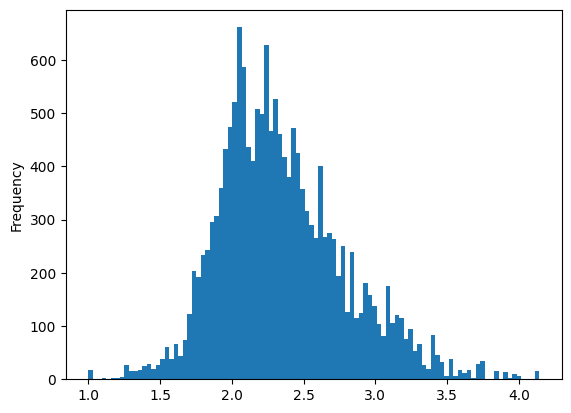

In [10]:
df["weight"].plot.hist(bins=100)

In [11]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]
tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg = (
    f"{asset_type}_{metric}",
    f"{asset_type}_{metric_pct_chg}",
    f"{asset_type}_{log_normalized_metric_pct_chg}",
)

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_log_normalized_yearly
5,2007,2.930576e+06,0.340367,0.824517
164,2008,2.615646e+06,0.346098,0.941139
266,2009,1.862297e+06,-0.364528,-1.087870
2085,2010,1.439064e+06,-0.449825,-1.428380
2469,2011,1.486421e+06,-0.201835,-0.583830
3765,2012,1.375874e+06,-0.043910,-0.029579
4310,2013,1.722702e+06,0.158959,0.538450
6052,2014,2.003999e+06,0.456528,1.143763
6307,2015,2.250190e+06,0.306198,0.823743
7909,2016,2.529195e+06,0.262074,0.626396


In [12]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_log_normalized_yearly
127,2021,2.816571e+06,-0.053462,-0.133839
1907,2022,3.951694e+06,0.228788,0.610076


In [13]:
from jre_utils.process import get_window

idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[tmp_normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = get_window(df, area_code, year - years_ahead, 5)

print(f"Target: {target}")
window[factor_columns + combined_core_columns]
# window

Target: -0.1338394340306548


,population_log_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_log_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,land_yearly_price_growth_log_normalized_yearly,condo_yearly_price_growth_log_normalized_yearly,building_yearly_price_growth_log_normalized_yearly,land_count_growth_normalized_yearly,condo_count_growth_normalized_yearly,building_count_growth_normalized_yearly,land_metric_pct_chg_is_available,condo_metric_pct_chg_is_available,building_metric_pct_chg_is_available
10913,1.094578,1.181180,-0.165600,3.536982,1.902188,2.662955,1,1,1,1,0.738795,0.377073,0.296820,0.354673,-0.406537,-0.164742,1.0,1.0,1.0
13045,1.110245,1.490954,0.894214,4.079340,7.613134,1.466553,1,1,1,1,1.262604,0.434792,0.358558,-0.524940,0.793775,-0.149857,1.0,1.0,1.0
14607,1.130387,1.515889,0.557545,4.132062,1.530660,1.819093,1,1,1,1,-0.401975,-0.174047,0.334598,0.526736,-0.198009,-0.575711,1.0,1.0,1.0
15352,1.151447,1.246128,0.216520,3.300576,4.411286,2.433750,1,1,1,1,0.239991,0.035429,0.369424,-0.204444,-0.579205,0.322578,1.0,1.0,1.0
16622,1.166419,2.205573,1.541510,3.242182,0.934724,1.958831,1,1,1,1,-0.536878,-0.049230,-0.147930,-0.210356,0.534246,-0.303215,1.0,1.0,1.0


In [14]:
# window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [15]:
window_length = 5

In [16]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg] + extra_prediction_columns,
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    shift=years_ahead,
    window_length=window_length
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg] + extra_prediction_columns,
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
    shift=years_ahead,
    window_length=window_length
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 21) (7,) [-1.20081597  0.48576206  0.11515896  0.13258331  0.31768727 -0.33163257
  0.00383251] [2.31739196]
1 (1, 21) (7,) [-3.03713366  0.82693264  0.28808737  0.0337483   0.58296874  0.
  0.59352781] [2.54294671]
2 (1, 21) (7,) [0.24519161 1.72378349 0.88378859 0.39202531 1.72756897 0.13373292
 1.25536643] [3.13587287]
3 (1, 21) (7,) [ 1.28767646  0.40469079  0.06943735 -0.03099585 -0.010143   -0.62346397
  0.21975239] [2.26379411]
0 torch.Size([5, 21]) torch.Size([7]) tensor([-1.2008,  0.4858,  0.1152,  0.1326,  0.3177, -0.3316,  0.0038]) tensor([2.3174])
1 torch.Size([5, 21]) torch.Size([7]) tensor([-3.0371,  0.8269,  0.2881,  0.0337,  0.5830,  0.0000,  0.5935]) tensor([2.5429])
2 torch.Size([5, 21]) torch.Size([7]) tensor([0.2452, 1.7238, 0.8838, 0.3920, 1.7276, 0.1337, 1.2554]) tensor([3.1359])
3 torch.Size([5, 21]) torch.Size([7]) tensor([ 1.2877,  0.4047,  0.0694, -0.0310, -0.0101, -0.6235,  0.2198]) tensor([2.2638])


In [17]:
BATCH_SIZE = 256

In [18]:
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"] + extra_prediction_columns,
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"] + extra_prediction_columns,
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

In [19]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [20]:
len(train_dataloader)

110

### Building the Transformer Model


In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [22]:
# plot num weights over performance to see if size matters at all (H0: it doesn't matter)
n_features = len(feature_columns)
d_model = 128
d_hid = 128
nlayers = 4
nhead = 4
dropout = 0.1 
enc_dropout = 0.0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    target_size=len(extra_prediction_columns) + 1,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)

In [23]:
model.eval()

r2_score = R2Score(device=device)
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)
        r2_score.update(
            outputs[:, 0].unsqueeze(1).to(device),
            batch["target"][:, 0].unsqueeze(1).to(device),  # get the first column
        )

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())
        print("R2_score:", r2_score.compute().item())

        break

torch.Size([256, 5, 21]) torch.Size([256, 5]) torch.Size([256, 7]) torch.Size([256, 1])
torch.Size([256, 7])
Loss: 1.5189658403396606
R2_score: -0.35095930099487305


In [24]:
learning_rate = 1e-4  # 3e-4
weight_decay = 0.1  # 1
num_epochs = 1000

In [25]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [26]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 3.7071, Eval Loss: 2.7830
Train R^2: -0.0330, Eval R^2: 0.0170
Epoch: 1
Train Loss: 3.2774, Eval Loss: 2.6381
Train R^2: 0.0137, Eval R^2: 0.0383
Epoch: 2
Train Loss: 3.1876, Eval Loss: 2.5462
Train R^2: 0.0374, Eval R^2: 0.0713
Epoch: 3
Train Loss: 3.1237, Eval Loss: 2.5010
Train R^2: 0.0572, Eval R^2: 0.0885
Epoch: 4
Train Loss: 3.0811, Eval Loss: 2.4808
Train R^2: 0.0698, Eval R^2: 0.0922
Epoch: 5
Train Loss: 3.0441, Eval Loss: 2.4864
Train R^2: 0.0758, Eval R^2: 0.0912
Epoch: 6
Train Loss: 3.0023, Eval Loss: 2.5071
Train R^2: 0.0825, Eval R^2: 0.0872
Epoch: 7
Train Loss: 2.9708, Eval Loss: 2.5234
Train R^2: 0.0856, Eval R^2: 0.0840
Epoch: 8
Train Loss: 2.9462, Eval Loss: 2.5557
Train R^2: 0.0877, Eval R^2: 0.0773
Epoch: 9
Train Loss: 2.9273, Eval Loss: 2.5843
Train R^2: 0.0901, Eval R^2: 0.0710
Epoch: 10
Train Loss: 2.9154, Eval Loss: 2.6042
Train R^2: 0.0922, Eval R^2: 0.0588
Epoch: 11
Train Loss: 2.8985, Eval Loss: 2.6526
Train R^2: 0.0945, Eval R^2: 0.0520
E

KeyboardInterrupt: 

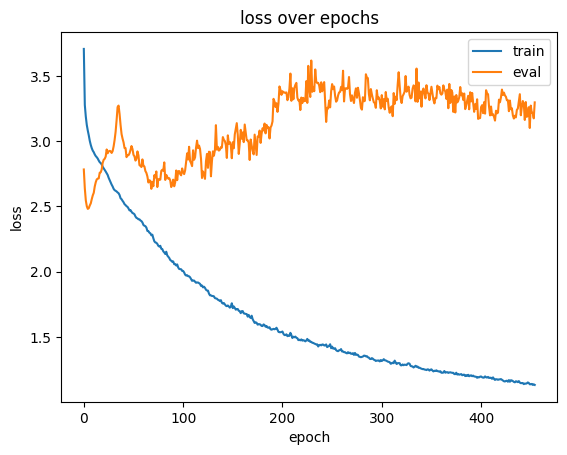

In [27]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

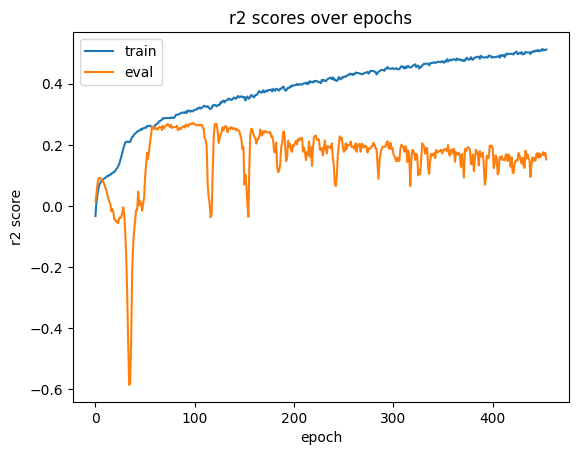

In [28]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [350]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 4.2473
Eval R2: 0.2815


In [135]:
years = [2021, 2022]

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(
        model, row["area_code"], row["year"], row["asset_type"]
    ),
    axis=1,
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

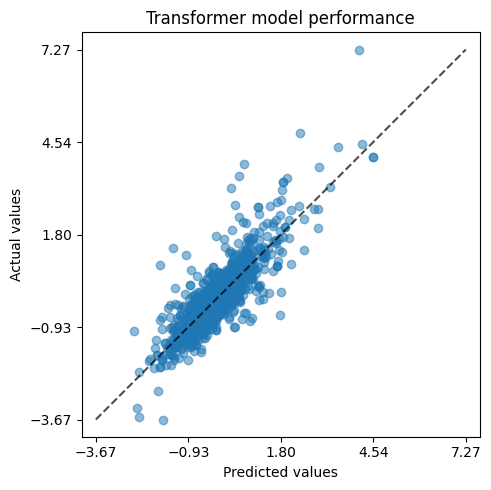

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

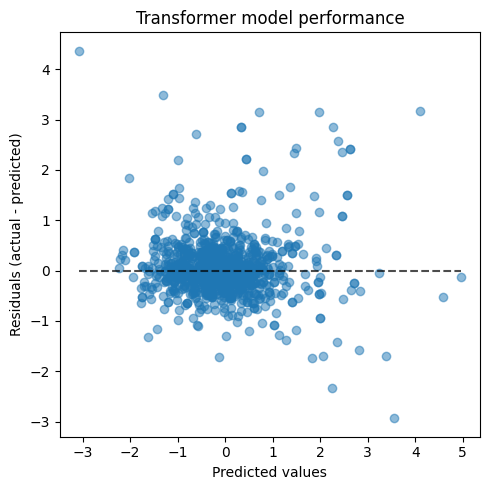

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [221]:
model

TimeSeriesTransformerModel(
  (embedding): Linear(in_features=11, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [319]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 51393
